In [26]:
# get matplotlib configuration
%run plot_conf.py

In [27]:
from torch import nn
import torch.nn.functional as f
from torch.autograd import Variable as V
from math import ceil

KERNEL_SIZE = 3
PADDING = KERNEL_SIZE // 2
KERNEL_STRIDE = 2
OUTPUT_ADJUST = KERNEL_SIZE - 2 * PADDING

up_sampler = list()

class Model02(nn.Module):
    """
    Generate a constructor for model_02 type of network
    """

    def __init__(self, network_size: tuple, input_spatial_size: tuple) -> None:
        """
        Initialise Model02 constructor

        :param network_size: (n, h1, h2, ..., emb_size, nb_videos)
        :type network_size: tuple
        :param input_spatial_size: (height, width)
        :type input_spatial_size: tuple
        """
        super().__init__()
        self.hidden_layers = len(network_size) - 2

        print('\n{:-^80}'.format(' Building model Model02 '))
        print('Hidden layers:', self.hidden_layers)
        print('Net sizing:', network_size)
        print('Input spatial size: {} x {}'.format(network_size[0], input_spatial_size))

        # main auto-encoder blocks
        self.activation_size = [input_spatial_size]
        for layer in range(0, self.hidden_layers):
            # print some annotation when building model
            print('{:-<80}'.format('Layer ' + str(layer + 1) + ' '))
            print('Bottom size: {} x {}'.format(network_size[layer], self.activation_size[-1]))
            self.activation_size.append(tuple(ceil(s / 2) for s in self.activation_size[layer]))
            print('Top size: {} x {}'.format(network_size[layer + 1], self.activation_size[-1]))

            # init D (discriminative) blocks
            multiplier = layer and 2 or 1  # D_n, n > 1, has intra-layer feedback
            setattr(self, 'D_' + str(layer + 1), nn.Conv2d(
                in_channels=network_size[layer] * multiplier, out_channels=network_size[layer + 1],
                kernel_size=KERNEL_SIZE, stride=KERNEL_STRIDE, padding=PADDING
            ))
            setattr(self, 'BN_D_' + str(layer + 1), nn.BatchNorm2d(network_size[layer + 1]))

            # init G (generative) blocks
            setattr(self, 'G_' + str(layer + 1), nn.ConvTranspose2d(
                in_channels=network_size[layer + 1], out_channels=network_size[layer],
                kernel_size=KERNEL_SIZE, stride=KERNEL_STRIDE, padding=PADDING
            ))
            setattr(self, 'BN_G_' + str(layer + 1), nn.BatchNorm2d(network_size[layer]))
            
            # create up samplers
            up_sampler.append(nn.ConvTranspose2d(
                in_channels=1, out_channels=1,
                kernel_size=KERNEL_SIZE, stride=KERNEL_STRIDE, padding=PADDING, bias=False
            ).cuda())
            up_sampler[-1].weight.data.fill_(1)

        # init auxiliary classifier
        print('{:-<80}'.format('Classifier '))
        print(network_size[-2], '-->', network_size[-1])
        self.average = nn.AvgPool2d(self.activation_size[-1])
        self.stabiliser = nn.Linear(network_size[-2], network_size[-1])
        print(80 * '-', end='\n\n')

    def forward(self, x, state):
        activation_sizes = [x.size()]  # start from the input
        residuals = list()
        map_means = list()
        masks = list()
        state = state or [None] * (self.hidden_layers - 1)
        for layer in range(0, self.hidden_layers):  # connect discriminative blocks
            if layer:  # concat the input with the state for D_n, n > 1
                s = state[layer - 1] or V(x.data.clone().zero_())
                x = torch.cat((x, s), 1)
            x = getattr(self, 'D_' + str(layer + 1))(x)
            residuals.append(x)
            x = f.relu(x)
            map_means.append(x.data.mean(1))  # feature maps from a given layer
            x = getattr(self, 'BN_D_' + str(layer + 1))(x)
            activation_sizes.append(x.size())  # cache output size for later retrieval
        for layer in reversed(range(0, self.hidden_layers)):  # connect generative blocks
            x = getattr(self, 'G_' + str(layer + 1))(x, activation_sizes[layer])
            if layer:
                state[layer - 1] = x
                x += residuals[layer - 1]
            x = f.relu(x)
            x = getattr(self, 'BN_G_' + str(layer + 1))(x)
            m = map_means[layer].clone()
            if masks:
                m = m * masks[-1]
            masks.append(up_sampler[layer](V(m, volatile=True), activation_sizes[layer]).data)
            
        x_mean = self.average(residuals[-1])
        video_index = self.stabiliser(x_mean.view(x_mean.size(0), -1))

        return (x, state), (x_mean, video_index), (map_means, masks)

In [ ]:
size = (3, 32, 64, 128, 256, 256, 256)
map_model = Model02(size + (35,), (256, 256)).cuda()
(_, _), (_, _), (maps, masks) = map_model(V(torch.zeros(3, 256, 256).cuda().unsqueeze(0), volatile=True), None)

In [ ]:
size = (3, 32, 64, 128, 256, 256, 256)
class Capsule(nn.Module):

    def __init__(self):
        super().__init__()
        self.inner_model = Model02(size + (35,), (256, 256))

    def forward(self, x):
        (_, _), (_, video_index) = self.inner_model(x, None)
        return video_index

model = Capsule()

In [ ]:
import torch

mod_D = nn.DataParallel(model).cuda()
checkpoint = torch.load('object-model02D-backup/model_best.pth.tar')
mod_D.load_state_dict(checkpoint['state_dict'])
mod_D.eval();

In [28]:
import torchvision.transforms as transforms
import torch

trs_256 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Scale(256),
        transforms.CenterCrop(256),
        transforms.ToTensor()
])

object_loader = torch.load('/home/atcold/MatchNet2/val_data.tar')

In [29]:
from torch.nn.functional import softmax
from ipywidgets import FloatProgress
from IPython.display import display
from skvideo.io import FFmpegReader

In [30]:
size = (3, 32, 64, 128, 256, 256, 256)
# network_035 = torch.load('../results/035/model.pth.tar')
# net_035_dict = network_035.state_dict()
network_036 = torch.load('../results/036/model.pth.tar')
net_036_dict = network_036.state_dict()
match_net = Model02(size + (35,), (256, 256))
# match_net.load_state_dict(net_035_dict)
match_net.load_state_dict(net_036_dict)
match_net.eval();
match_net.cuda(0);


---------------------------- Building model Model02 ----------------------------
Hidden layers: 6
Net sizing: (3, 32, 64, 128, 256, 256, 256, 35)
Input spatial size: 3 x (256, 256)
Layer 1 ------------------------------------------------------------------------
Bottom size: 3 x (256, 256)
Top size: 32 x (128, 128)
Layer 2 ------------------------------------------------------------------------
Bottom size: 32 x (128, 128)
Top size: 64 x (64, 64)
Layer 3 ------------------------------------------------------------------------
Bottom size: 64 x (64, 64)
Top size: 128 x (32, 32)
Layer 4 ------------------------------------------------------------------------
Bottom size: 128 x (32, 32)
Top size: 256 x (16, 16)
Layer 5 ------------------------------------------------------------------------
Bottom size: 256 x (16, 16)
Top size: 256 x (8, 8)
Layer 6 ------------------------------------------------------------------------
Bottom size: 256 x (8, 8)
Top size: 256 x (4, 4)
Classifier ---------

In [31]:
vid = FFmpegReader('/home/atcold/Videos/20170418_113638.mp4')
vid_iter = vid.nextFrame()
nb_frames = vid.inputframenum
prg_bar = FloatProgress(min=0, max=nb_frames); display(prg_bar)
prob_mat = {
    'net 036': torch.Tensor(nb_frames, match_net.stabiliser.out_features),
}
mask_mat = torch.Tensor(nb_frames, 1, 256, 256)
x_mat = torch.Tensor(nb_frames, 3, 256, 256)

state = None
for idx, x in enumerate(vid_iter):
    x = trs_256(x)
    x_mat[idx].copy_(x)
    (_, state), (_, logit), (maps, masks) = match_net(V(x.cuda().unsqueeze(0), volatile=True), state)
    h_x = softmax(logit).data.squeeze(0)
    prob_mat['net 036'][idx].copy_(h_x)
    mask_mat[idx].copy_(masks[-1])
    prg_bar.value += 1

In [ ]:
nb_frames = len(x_mat)
prg_bar = FloatProgress(min=0, max=nb_frames); display(prg_bar)
prob_mat = {
    'net 035': torch.Tensor(nb_frames, match_net.stabiliser.out_features),
}

state = None
for idx, x in enumerate(x_mat):
    (_, state), (_, logit) = match_net(V(x.cuda().unsqueeze(0), volatile=True), state)
    h_x = softmax(logit).data.squeeze(0)
    prob_mat['net 035'][idx].copy_(h_x)
    prg_bar.value += 1

In [ ]:
%matplotlib inline
plt.figure(figsize=(16, 8))
nb_classes = 5
count = 1
for m, p in prob_mat.items():
    video_mean_prob = prob_mat[m].mean(dim=0).squeeze()
    probs, srt_idx = video_mean_prob.sort(0, True)
    top_n_classes = prob_mat[m].index_select(1, srt_idx[:5])
    # and plot them
#     plt.subplot(1, 2, count); count += 1
    plt.plot(top_n_classes.numpy())
    plt.legend([object_loader.classes[srt_idx[i]] for i in range(5)])
    plt.title(m)

In [10]:
def to_view(a, b_n_w=False):
    if b_n_w: return a.cpu().numpy()
    return a.cpu().numpy().transpose((1, 2, 0))

In [11]:
green_mask = torch.zeros(3, 256, 256)
my_chair_seq = list()
def view_masked(x, mask, a=5):
    mask_min = mask.min()
    mask_range = mask.max() - mask_min
    green_mask[1] = ((mask - mask_min) / mask_range).squeeze(0).cpu()
    masked = a * green_mask + x
    masked[masked > 1] = 1
    plt.imshow(to_view(masked)); plt.axis('off')
#     torch.save(masked, 'my_chair.pth')
    my_chair_seq.append(masked.clone())

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(12,8))
nb_classes = 5
count = 1
for idx, m in enumerate(mask_mat):
    top_n_classes = prob_mat['net 036'].index_select(1, srt_idx[:5])[0:idx+1]
    # and plot them
    plt.subplot(211);
    plt.cla()
    plt.axis([0, 350, 0, 1])
    plt.plot(top_n_classes.numpy())
    plt.legend([object_loader.classes[srt_idx[i]] for i in range(5)])
    plt.subplot(212)
    view_masked(x_mat[idx], mask_mat[idx])
    plt.subplots_adjust(left=0.03, bottom=0, right=0.99, top=0.99, wspace=0, hspace=0.1)
#     fig.canvas.draw()
    fig.savefig('saliency036/{:03d}.png'.format(idx))

# Generate GIF animation with
# convert -dispose none -delay 0 -size 864x576 'xc:#333' -dispose previous -delay 10 saliency/*.png test_sal.gif

In [ ]:
# torch.save(my_chair_seq, 'my_chair_seq.pth')

In [32]:
act_s = map_model.activation_size

In [33]:
for l, m in enumerate(maps):
    print('Layer', l + 1, 'map size:', tuple(m.size()))

Layer 1 map size: (1, 1, 128, 128)
Layer 2 map size: (1, 1, 64, 64)
Layer 3 map size: (1, 1, 32, 32)
Layer 4 map size: (1, 1, 16, 16)
Layer 5 map size: (1, 1, 8, 8)
Layer 6 map size: (1, 1, 4, 4)


In [34]:
up_maps = list()
for l, m in enumerate(reversed(maps)):
    up_maps.append(m)
    layer = len(maps) - 1 - l
    for up_l in range(0, len(up_maps)):
        up_maps[up_l] = up_sampler[layer](
            V(up_maps[up_l], volatile=True), act_s[layer]
        ).data
    print('Layer', len(maps) - l, 'map size:', tuple(m.size()))
    print([tuple(u.size()) for u in up_maps])

Layer 6 map size: (1, 1, 4, 4)
[(1, 1, 8, 8)]
Layer 5 map size: (1, 1, 8, 8)
[(1, 1, 16, 16), (1, 1, 16, 16)]
Layer 4 map size: (1, 1, 16, 16)
[(1, 1, 32, 32), (1, 1, 32, 32), (1, 1, 32, 32)]
Layer 3 map size: (1, 1, 32, 32)
[(1, 1, 64, 64), (1, 1, 64, 64), (1, 1, 64, 64), (1, 1, 64, 64)]
Layer 2 map size: (1, 1, 64, 64)
[(1, 1, 128, 128), (1, 1, 128, 128), (1, 1, 128, 128), (1, 1, 128, 128), (1, 1, 128, 128)]
Layer 1 map size: (1, 1, 128, 128)
[(1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256), (1, 1, 256, 256)]


In [35]:
def to_view(a, b_n_w=False):
    if b_n_w: return a.cpu().numpy()
    return a.cpu().numpy().transpose((1, 2, 0))

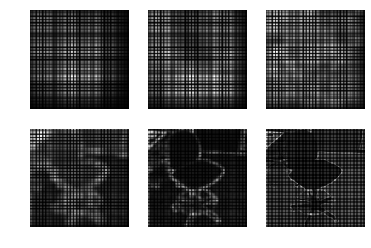

In [36]:
%matplotlib inline
for c, m in enumerate(up_maps):
    plt.subplot(2,3,c + 1)
    plt.imshow(to_view(m.squeeze(), b_n_w=True), cmap='gray'); plt.axis('off')

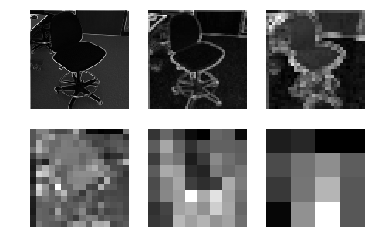

In [37]:
for c, m in enumerate(maps):
    plt.subplot(2,3,c + 1)
    plt.imshow(to_view(m.squeeze(), b_n_w=True), cmap='gray'); plt.axis('off')

In [38]:
mask = list()
for l, m in enumerate(reversed(maps)):
    layer = len(maps) - 1 - l
    if mask:
        m = m * mask[-1]
    mask.append(up_sampler[layer](
            V(m, volatile=True), act_s[layer]
        ).data)

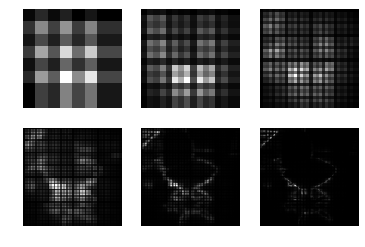

In [39]:
for c, m in enumerate(mask):
    plt.subplot(2,3,c + 1)
    plt.imshow(to_view(m.squeeze(), b_n_w=True), cmap='gray'); plt.axis('off')

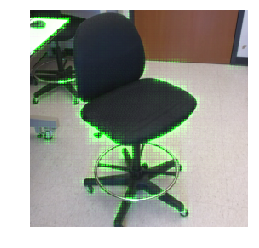

In [40]:
green_mask = torch.zeros(3, 256, 256)
def view_masked2(x, mask, a=5):
    mask_min = mask.min()
    mask_range = mask.max() - mask_min
    green_mask[1] = ((mask - mask_min) / mask_range).squeeze(0).cpu()
    masked = a * green_mask + x
    masked[masked > 1] = 1
    plt.imshow(to_view(masked)); plt.axis('off')
view_masked2(x_mat[-1], masks[-1])